In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib



In [2]:
# Load datasets with default dtypes (you can specify dtypes later if needed)
gym_members_df = pd.read_csv('gym_members_exercise_tracking.csv')
workout_tracker_df = pd.read_csv('workout_fitness_tracker_data.csv')

# Fast vectorized text cleaning function for workout columns
def fast_clean_text(series):
    return (series.str.lower()
                  .str.strip()
                  .str.replace('[-_]', ' ', regex=True)
                  .str.replace('[^a-z0-9 ]', '', regex=True)
                  .str.replace(r'\s+', ' ', regex=True))

gym_members_df['workout_clean'] = fast_clean_text(gym_members_df['Workout_Type'])
workout_tracker_df['workout_clean'] = fast_clean_text(workout_tracker_df['Workout Type'])

# Convert keys to categorical type for faster merge
gym_members_df['workout_clean'] = gym_members_df['workout_clean'].astype('category')
workout_tracker_df['workout_clean'] = workout_tracker_df['workout_clean'].astype('category')

# Merge datasets on cleaned workout names (inner join)
combined_df = pd.merge(
    gym_members_df,
    workout_tracker_df,
    on='workout_clean',
    how='inner',
    suffixes=('_gym', '_tracker'),
    copy=False
)

print(f"Combined DataFrame shape: {combined_df.shape}")



Combined DataFrame shape: (1630286, 36)


In [3]:
# Fill missing values safely

# Separate numerical and categorical columns
num_cols = combined_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = combined_df.select_dtypes(include=['category', 'object']).columns.tolist()

# Fill numerical columns with median
for col in num_cols:
    median_val = combined_df[col].median()
    combined_df[col] = combined_df[col].fillna(median_val)

# Fill categorical columns with 'missing' category
import pandas as pd

for col in cat_cols:
    if isinstance(combined_df[col].dtype, pd.CategoricalDtype):
        combined_df[col] = combined_df[col].cat.add_categories(['missing'])
    combined_df[col] = combined_df[col].fillna('missing')


# Define features and target columns
feature_cols = [
    'Age_gym', 'Gender_gym', 'Weight (kg)_gym', 'Height (m)', 'Calories_Burned_gym',
    'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
    'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken',
    'Distance (km)', 'Workout Intensity'
]

# Keep only features present in combined_df
feature_cols = [f for f in feature_cols if f in combined_df.columns]
print(f"Using features ({len(feature_cols)}): {feature_cols}")

X = combined_df[feature_cols].copy()

# Select target column
if 'Experience_Level' in combined_df.columns:
    y = combined_df['Experience_Level']
    print("Using 'Experience_Level' as target")
elif 'Workout Intensity' in combined_df.columns:
    y = combined_df['Workout Intensity']
    print("Using 'Workout Intensity' as target")
else:
    raise ValueError("No target column found! Please check your dataset.")



Using features (14): ['Age_gym', 'Gender_gym', 'Weight (kg)_gym', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 'Workout Intensity']
Using 'Experience_Level' as target


In [4]:
categorical_cols = ['Gender_gym', 'Workout Intensity']

for col in categorical_cols:
    if col in X.columns:
        # Use pandas categorical codes (fast and efficient)
        X[col] = X[col].astype('category').cat.codes

print("Categorical encoding completed:")
print(X[categorical_cols].head())


Categorical encoding completed:
   Gender_gym  Workout Intensity
0           1                  1
1           1                  1
2           1                  0
3           1                  2
4           1                  0


In [5]:
numerical_cols = [col for col in feature_cols if col not in categorical_cols]
print(f"Numerical features to scale ({len(numerical_cols)}): {numerical_cols}")

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("Numerical features scaled:")
print(X[numerical_cols].head())


Numerical features to scale (12): ['Age_gym', 'Weight (kg)_gym', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)']
Numerical features scaled:
    Age_gym  Weight (kg)_gym  Height (m)   Max_BPM   Avg_BPM  Resting_BPM  \
0  1.421873          0.68135   -0.098365  0.009916  0.923101    -0.304181   
1  1.421873          0.68135   -0.098365  0.009916  0.923101    -0.304181   
2  1.421873          0.68135   -0.098365  0.009916  0.923101    -0.304181   
3  1.421873          0.68135   -0.098365  0.009916  0.923101    -0.304181   
4  1.421873          0.68135   -0.098365  0.009916  0.923101    -0.304181   

   Session_Duration (hours)  Workout Duration (mins)  Calories Burned  \
0                   1.26396                -1.690771        -0.958635   
1                   1.26396                -1.059319        -0.993016   
2                   1.26396                -0.459

In [6]:
# Encode target variable if categorical
if y.dtype == 'object' or str(y.dtype) == 'category':
    y = y.astype('category').cat.codes

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Train Random Forest model
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification report:\n", classification_report(y_test, y_pred))


Train shape: (1304228, 14), Test shape: (326058, 14)
Test accuracy: 1.0000
Classification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00    125950
           2       1.00      1.00      1.00    136005
           3       1.00      1.00      1.00     64103

    accuracy                           1.00    326058
   macro avg       1.00      1.00      1.00    326058
weighted avg       1.00      1.00      1.00    326058



In [7]:
# Cell 7: Save Model, Scaler, and Category Mappings
print("Saving model, scaler, and category mappings...")

joblib.dump(model, 'rf_experience_level_model.joblib')
joblib.dump(scaler, 'feature_scaler.joblib')

# Save category mappings for decoding later (optional)
category_mappings = {}
for col in categorical_cols:
    if col in X.columns:
        category_mappings[col] = X[col].astype('category').cat.categories.tolist()
joblib.dump(category_mappings, 'category_mappings.joblib')

print("Model, scaler, and category mappings saved successfully.")


Saving model, scaler, and category mappings...
Model, scaler, and category mappings saved successfully.


In [8]:
import joblib
import pandas as pd

# Load saved objects
model = joblib.load('rf_experience_level_model.joblib')
scaler = joblib.load('feature_scaler.joblib')
category_mappings = joblib.load('category_mappings.joblib')

# The feature columns used during training — must match your original training setup
feature_cols = [
    'Age_gym', 'Gender_gym', 'Weight (kg)_gym', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'Workout Duration (mins)', 
    'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken', 'Distance (km)', 
    'Workout Intensity'
]

categorical_cols = ['Gender_gym', 'Workout Intensity']

# Define new sample ONLY with the features used for model / scaler training
new_sample = {
    'Age_gym': 30,
    'Gender_gym': 'male',           # categorical
    'Weight (kg)_gym': 75,
    'Height (m)': 1.75,
    'Max_BPM': 160,
    'Avg_BPM': 140,
    'Resting_BPM': 70,
    'Session_Duration (hours)': 1,
    'Workout Duration (mins)': 60,
    'Calories Burned': 450,
    'Heart Rate (bpm)': 138,
    'Steps Taken': 8000,
    'Distance (km)': 6.0,
    'Workout Intensity': 'medium'   # categorical
}

# Create the DataFrame in the exact same column order
df_sample = pd.DataFrame([new_sample], columns=feature_cols)

# Encode categorical columns using saved category mappings
for col in categorical_cols:
    if col in df_sample.columns:
        categories = category_mappings.get(col, [])
        df_sample[col] = df_sample[col].apply(lambda x: categories.index(x) if x in categories else -1)

# Separate numerical columns (features excluding categorical)
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Now transform numerical features — this must match scaler.fit features exactly
df_sample[numerical_cols] = scaler.transform(df_sample[numerical_cols])

# Predict
predicted_code = model.predict(df_sample)[0]
print(f"Predicted encoded class: {predicted_code}")


Predicted encoded class: 2


Test Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    125950
           2       1.00      1.00      1.00    136005
           3       1.00      1.00      1.00     64103

    accuracy                           1.00    326058
   macro avg       1.00      1.00      1.00    326058
weighted avg       1.00      1.00      1.00    326058



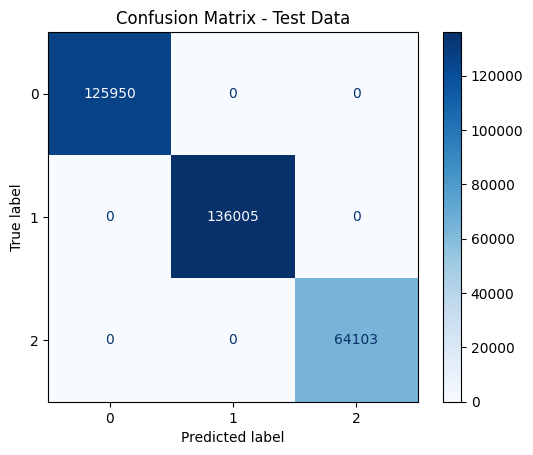

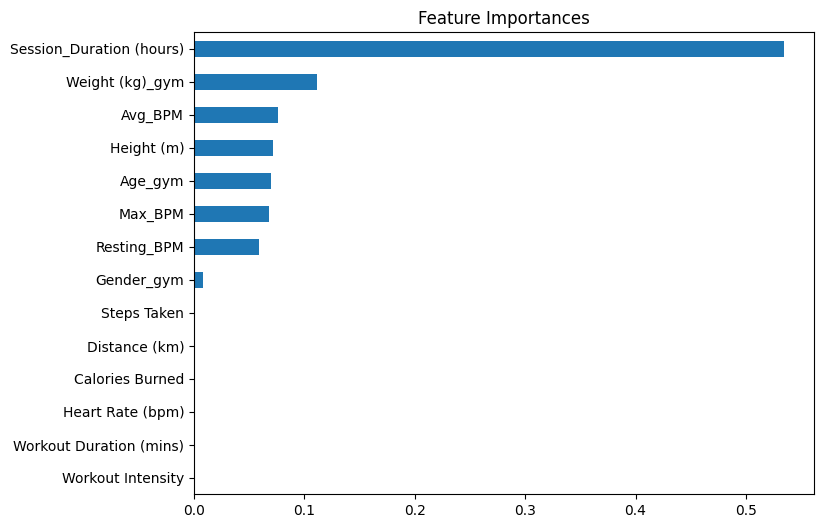

In [9]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Load the saved model and scaler ---
model = joblib.load('rf_experience_level_model.joblib')
scaler = joblib.load('feature_scaler.joblib')

# Load category mappings (for categorical encoding)
category_mappings = joblib.load('category_mappings.joblib')
categorical_cols = ['Gender_gym', 'Workout Intensity']

# --- Step 2: Prepare your test data ---

# Assuming you have saved or have access to your test dataset (X_test_raw, y_test_raw)
# If you only have combined_df and splitting was done previously in Cell 6,
# re-run train_test_split to get X_test and y_test:

from sklearn.model_selection import train_test_split

# Re-load or access your full data and features (replace this as per your actual environment)
# Example:
# combined_df = pd.read_csv('your_combined_preprocessed_data.csv')  # If saved externally

# Define feature columns exactly as in training
feature_cols = [
    'Age_gym', 'Gender_gym', 'Weight (kg)_gym', 'Height (m)', 'Calories_Burned_gym',
    'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
    'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken',
    'Distance (km)', 'Workout Intensity'
]

feature_cols = [f for f in feature_cols if f in combined_df.columns]

# Define target column
if 'Experience_Level' in combined_df.columns:
    target_col = 'Experience_Level'
elif 'Workout Intensity' in combined_df.columns:
    target_col = 'Workout Intensity'
else:
    raise ValueError("No target column found!")

# Get X and y for test
X_full = combined_df[feature_cols].copy()
y_full = combined_df[target_col].copy()

# Encode categorical columns in X_full same as training
for col in categorical_cols:
    if col in X_full.columns:
        categories = category_mappings.get(col, [])
        X_full[col] = X_full[col].astype(str).apply(lambda x: categories.index(x) if x in categories else -1)

# Encode target if categorical
if y_full.dtype == 'object' or str(y_full.dtype) == 'category':
    y_full = y_full.astype('category').cat.codes

# Split (same as training split ratios and seed to get same X_test and y_test)
_, X_test, _, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Scale numerical features in X_test
numerical_cols = [col for col in feature_cols if col not in categorical_cols]
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# --- Step 3: Predict on test data ---
y_pred = model.predict(X_test)

# --- Step 4: Evaluate metrics ---

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# Classification report: precision, recall, f1-score per class
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()

# --- Optional: Feature importance plot ---
feature_importances = pd.Series(model.feature_importances_, index=feature_cols)
feature_importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importances")
plt.show()


In [10]:
# Assuming you have your full dataset `combined_df` and your original train-test split

from sklearn.model_selection import train_test_split

# Define features and target as done previously
feature_cols = [
    'Age_gym', 'Gender_gym', 'Weight (kg)_gym', 'Height (m)', 'Calories_Burned_gym',
    'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)',
    'Workout Duration (mins)', 'Calories Burned', 'Heart Rate (bpm)', 'Steps Taken',
    'Distance (km)', 'Workout Intensity'
]

feature_cols = [f for f in feature_cols if f in combined_df.columns]

if 'Experience_Level' in combined_df.columns:
    target_col = 'Experience_Level'
elif 'Workout Intensity' in combined_df.columns:
    target_col = 'Workout Intensity'
else:
    raise ValueError("No target column found!")

X_full = combined_df[feature_cols].copy()
y_full = combined_df[target_col].copy()

# Encode categorical columns same as training
categorical_cols = ['Gender_gym', 'Workout Intensity']
for col in categorical_cols:
    if col in X_full.columns:
        categories = category_mappings.get(col, [])
        X_full[col] = X_full[col].astype(str).apply(lambda x: categories.index(x) if x in categories else -1)

# Encode target if categorical
if y_full.dtype == 'object' or str(y_full.dtype) == 'category':
    y_full = y_full.astype('category').cat.codes

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# Check for duplicates in train and test sets
train_test_intersection = pd.merge(
    X_train.reset_index(),
    X_test.reset_index(),
    on=feature_cols,
    how='inner',
    suffixes=('_train', '_test')
)

print(f"Number of duplicate rows in train and test: {len(train_test_intersection)}")

if len(train_test_intersection) == 0:
    print("No duplicates found between train and test sets. No direct leakage here.")
else:
    print("Duplicates found between train and test sets! Possible leakage.")


Number of duplicate rows in train and test: 0
No duplicates found between train and test sets. No direct leakage here.


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Using the previously prepared X_full and y_full (with categorical encoding done)

clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Stratified K-Fold to maintain label distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(clf, X_full, y_full, cv=skf, scoring='accuracy', n_jobs=-1)

print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_scores):.4f}")


In [ ]:
print("hello")